### Imports

In [4]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

### ---> Basic
import numpy as np
import time

### ---> Cosmo
#from colossus.tests import run_tests
from colossus.cosmology import cosmology
import astropy.cosmology
from src.GWGC_cross_corr import *



### ---> plotting
from matplotlib import pyplot as plt

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap


import seaborn as sns
import matplotlib

### ---> Gaussian Processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import scipy.integrate as integrate



%matplotlib notebook
#%matplotlib inline



 ### Some utility functions for later

In [5]:
# This function specifies your fiducial model
def fiducial_ratios(z_lst, xi_tmp = 1.4, n = 1.):
    DL_ratio_fiducial = (xi_tmp + (1. - xi_tmp)/(1. + z_lst)**n)#np.ones(len(z_lst))

    bias_fiducial = [1.]

    return [DL_ratio_fiducial, bias_fiducial]

def GWGC_plotting(Xi_0, n, ell_index):
    
    DL_ratio = (Xi_0 + (1. - Xi_0)/(1. + C_ell_instance.z_lst)**n)
    bias_ratio = np.ones(len(C_ell_instance.z_lst))
    
    GWGC = C_ell_instance.C_ell(DL_ratio, bias_ratio, output_mode = "separate")["GWGC"][ell_index]
    
    Cov_tmp = stat_instance.mock_data(DL_ratio, bias_ratio, \
                                  observable_mode = "GWGC_only")["Cov_mat"][:,:,ell_index]
    sigmas = np.sqrt(np.diagonal(Cov_tmp))
    
    return {"horizontal_axis":z_bin_centers, "fiducial":GWGC, "upper":GWGC + sigmas/2., "lower":GWGC - sigmas/2.}

def GP(training_pos, training_vals, correlation_length, z_lst):

    kernel = RBF(correlation_length, (correlation_length, correlation_length))
    gp = GaussianProcessRegressor(kernel=kernel)
    
    gp.fit(np.array(training_pos)[:,np.newaxis], training_vals)
    
    return gp.predict(z_lst[:, np.newaxis])

### Initialization

In [6]:
################# Specifications #################

ell_lst = np.arange(10., 101., 1.)

### --- Comoving number densities of mergers and galaxies --- ###
n_bar_GW_z = 3.*1e-6 # T_obs ndot_GW = 3e-6h^3Mpc^-3
n_bar_gal_z = 1e-3
#################################################################

### --- Bins --- ###
### Note that you should pass the
### central locations of the bins,
### and the (const) bin width
N_gal = 100
z_min, z_max = 0.1, 2.95
delta_z = 0.1#(z_max - z_min)/N_gal
z_bin_centers = np.linspace(0.5, 1.5, N_gal)#np.arange(z_min + delta_z/2., z_max, delta_z)

cosmo = cosmology.setCosmology('planck18')
N_DL = 1
minmax = np.array([0.7, 0.9])
DL_min, DL_max = fiducial_ratios(minmax)[0]*cosmo.luminosityDistance(minmax)  # in Mpc/h
delta_DL = (DL_max - DL_min)/N_DL
DL_bin_centers = np.arange(DL_min + delta_DL/2., DL_max, delta_DL)

survey_params = {"sigma_lnD":0.05, \
                 "ell_lst":ell_lst, \
                 "f_sky":0.5, \
                 "z_bin_centers":z_bin_centers, \
                 "delta_z":delta_z, \
                 "DL_bin_centers":DL_bin_centers, \
                 "delta_DL":delta_DL, \
                 "comoving_number_densities":np.array([n_bar_gal_z, n_bar_GW_z])}
####################


# Redshift range
z_min, z_max = 1e-3, 3.
z_array_length = 1e3
z_lst = np.linspace(z_min, z_max, z_array_length)

# This is the observable mode.
# Use "combined" for using all the spectra
# Use "GWGC_only" for using only the cross spectra
# Use "GWGW_only" for using only the GW auto spectra
# Use "GCGC_only" for using only the GC auto spectra
observable_mode = "combined"
###################################################################################



### --- Initialize the C_ells class --- ###
C_ell_instance = C_ells(survey_params, z_integration_lst = z_lst, verbose = True)

### --- Make a statistics instance --- ###
stat_instance = statistics(C_ell_instance)



Done: initialization of the survey specifications
Current cosmology:  {'flat': True, 'H0': 67.66, 'Om0': 0.3111, 'Ob0': 0.049, 'sigma8': 0.8102, 'ns': 0.9665, 'de_model': 'w0wa', 'w0': -1.0, 'wa': 0.0}
Done: setting up the cosmology


### Demonstrating the idea

0.7845897674560547


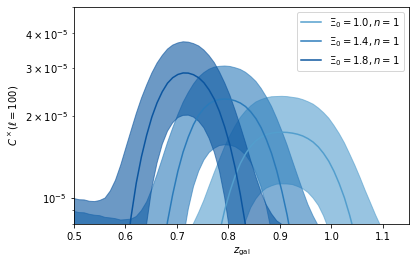

In [7]:
colorparams = [0.6, 1., 1.4, 1.8]
normalize = mcolors.Normalize(vmin=0.1, vmax=1.8)
colormap = ListedColormap(sns.color_palette("Blues").as_hex())


#sns.color_palette("rocket")#cm.viridis_r

#oguri_fig_1 = np.loadtxt("oguri_fig_1.csv", delimiter = ",")


fig = plt.figure()
ax = fig.gca()

start = time.time()


### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ###



plot_tmp = GWGC_plotting(Xi_0 = 1., n = 1., ell_index = 89)

color = colormap(normalize(1.))
ax.plot(plot_tmp["horizontal_axis"], plot_tmp["fiducial"], ls = "-", alpha = 1., c = color, \
        label = r"$\Xi_0 = 1.0, n = 1$")
ax.fill_between(plot_tmp["horizontal_axis"], plot_tmp["lower"], plot_tmp["upper"], \
                color = color, alpha = 0.6)


plot_tmp = GWGC_plotting(Xi_0 = 1.4, n = 1., ell_index = 89)

color = colormap(normalize(1.4))
ax.plot(plot_tmp["horizontal_axis"], plot_tmp["fiducial"], ls = "-", alpha = 1., c = color, \
        label = r"$\Xi_0 = 1.4, n = 1$")
ax.fill_between(plot_tmp["horizontal_axis"], plot_tmp["lower"], plot_tmp["upper"], \
                color = color, alpha = 0.6)


plot_tmp = GWGC_plotting(Xi_0 = 1.8, n = 1., ell_index = 89)

color = colormap(normalize(1.8))
ax.plot(plot_tmp["horizontal_axis"], plot_tmp["fiducial"], ls = "-", alpha = 1., c = color, \
        label = r"$\Xi_0 = 1.8, n = 1$")
ax.fill_between(plot_tmp["horizontal_axis"], plot_tmp["lower"], plot_tmp["upper"], \
                color = color, alpha = 0.6)
### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ### --- ###




end = time.time()
print(end - start)


ax.set_yscale("log")
ax.set_xlim([0.5, 1.15])
ax.set_ylim([8e-6, 5e-5])


ax.set_ylabel(r"$C^\times(\ell = 100)$")
ax.set_xlabel(r"$z_\mathrm{gal}$")

#ax.grid(which='both')
ax.legend()




### S/N and covariance

In [12]:
xi_tmp, n = 1.4, 1.

DLR, bias = fiducial_ratios(z_lst, xi_tmp = 1.4, n = 1.)

#fig = plt.figure()
#ax = fig.gca()

#ax.plot(C_ell_instance.z_lst, DLR)

#ax.set_xlabel(r"$z$")
#ax.set_ylabel(r"$D_\mathrm{GW}/D_\mathrm{EM}$")


### --- Change the Bins --- ###
### Note that you should pass the
### central locations of the bins,
### and the (const) bin width
N_gal = 12
z_min, z_max = 0.1, 2.95
delta_z = (z_max - z_min)/N_gal
z_bin_centers = np.arange(z_min + delta_z/2., z_max, delta_z) 
#z_bin_centers = np.linspace(0.2, 2.85, N_gal)
#delta_z = (max(z_bin_centers) - min(z_bin_centers))/(N_gal - 1.)

print("Centers of z bins = %s\n"%(z_bin_centers))
print("Left edges of z bins = %s"%(z_bin_centers - delta_z/2.))
print("Right edges of z bins = %s"%(z_bin_centers + delta_z/2.))

N_DL = 8

minmax = np.array([0.1, 3.])
DL_min, DL_max = (xi_tmp + (1. - xi_tmp)/(1. + minmax)**n)*cosmo.luminosityDistance(minmax)  # in Mpc/h

delta_DL = (DL_max - DL_min)/N_DL
DL_bin_centers = np.arange(DL_min + delta_DL/2., DL_max, delta_DL) 

print("Centers of DL bins = %s\n"%(DL_bin_centers))
print("Left edges of DL bins = %s\n"%(DL_bin_centers - delta_DL/2.))
print("Right edges of DL bins = %s\n"%(DL_bin_centers + delta_DL/2.))


### You again need to update the bin_params as we just modified it compared to the specifications file
survey_params["z_bin_centers"] = z_bin_centers
survey_params["delta_z"] = delta_z
survey_params["DL_bin_centers"] = DL_bin_centers
survey_params["delta_DL"] = delta_DL

survey_params["sigma_lnD"] = 0.05

survey_params["comoving_number_densities"] = np.array([1e-3, 3e-6])


### --- Initialize the C_ells class --- ###
C_ell_instance = C_ells(survey_params, z_integration_lst = z_lst, verbose = True)

### --- Make a statistics instance --- ###
stat_instance = statistics(C_ell_instance)

### --- This writes the covariance matrix, its inverse, and a generated mock data into files --- ###
data_dict = stat_instance.mock_data(DLR, bias, observable_mode = observable_mode)
mock_data, Cov_mat, inv_Cov_mat = data_dict["C_ell_mock"], data_dict["Cov_mat"], data_dict["inv_Cov_mat"]



gws = [r"$gw_1$", r"$gw_2$", r"$gw_3$", r"$gw_4$", r"$gw_5$", r"$gw_6$", r"$gw_7$", r"$gw_8$"]
gals = [r"$gal_1$", r"$gal_2$", r"$gal_3$", r"$gal_4$", r"$gal_5$", r"$gal_6$", \
          r"$gal_7$", r"$gal_8$", r"$gal_9$", r"$gal_{10}$", r"$gal_{11}$", r"$gal_{12}$"]



W_gal_lst, gal_normalization_lst = C_ell_instance.W_gal()
W_gw_lst, gw_normalization_lst = C_ell_instance.W_gw()

#print(gal_normalization_lst, gw_normalization_lst)
#W_gal_lst = (W_gal_lst.T*gal_normalization_lst).T
#W_gw_lst = (W_gw_lst.T*gw_normalization_lst).T



print("\n Num GW sources = ", gw_normalization_lst.sum()*2.*np.pi, "\n")

print("sigma DL = ", DL_bin_centers*survey_params["sigma_lnD"])
print("Width of the DL win function = ", delta_DL)


Centers of z bins = [0.21875 0.45625 0.69375 0.93125 1.16875 1.40625 1.64375 1.88125 2.11875
 2.35625 2.59375 2.83125]

Left edges of z bins = [0.1    0.3375 0.575  0.8125 1.05   1.2875 1.525  1.7625 2.     2.2375
 2.475  2.7125]
Right edges of z bins = [0.3375 0.575  0.8125 1.05   1.2875 1.525  1.7625 2.     2.2375 2.475
 2.7125 2.95  ]
Centers of DL bins = [ 1742.92584598  4561.45828917  7379.99073235 10198.52317554
 13017.05561872 15835.58806191 18654.1205051  21472.65294828]

Left edges of DL bins = [  333.65962439  3152.19206757  5970.72451076  8789.25695395
 11607.78939713 14426.32184032 17244.8542835  20063.38672669]

Right edges of DL bins = [ 3152.19206757  5970.72451076  8789.25695395 11607.78939713
 14426.32184032 17244.8542835  20063.38672669 22881.91916988]

Done: initialization of the survey specifications
Current cosmology:  {'flat': True, 'H0': 67.66, 'Om0': 0.3111, 'Ob0': 0.049, 'sigma8': 0.8102, 'ns': 0.9665, 'de_model': 'w0wa', 'w0': -1.0, 'wa': 0.0}
Done: setting up

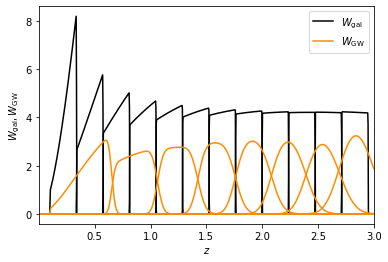

In [9]:
### ---> Visualization of the window functions




fig = plt.figure()
ax = fig.gca()


for tmp in W_gal_lst[0:-1]:
    plt.plot(C_ell_instance.z_lst, tmp, ls = "-", c = "black")
plt.plot(C_ell_instance.z_lst, W_gal_lst[-1], ls = "-", c = "black", label = r"$W_\mathrm{gal}$")
    
for tmp in W_gw_lst[0:-1]:
    plt.plot(C_ell_instance.z_lst, tmp, ls = "-", c = "darkorange")
plt.plot(C_ell_instance.z_lst, W_gw_lst[-1], ls = "-", c = "darkorange", label = r"$W_\mathrm{GW}$")
    
    
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$W_\mathrm{gal}, W_\mathrm{GW}$")

#ax.axvline(0.35)
#ax.axvline(0.1)
#ax.axvline(0.55)

ax.legend()
#max(z_lst)
ax.set_xlim(min(z_lst), max(z_lst))
#ax.set_ylim(1e-1, 1e1)

ax.set_yscale("linear")



#plt.savefig("Figs/window_functions.pdf")



In [10]:
GWGC_SN_sqr_lst = np.zeros(N_gal*N_DL)
GWGW_SN_sqr_lst = np.zeros(N_DL)
GCGC_SN_sqr_lst = np.zeros(N_gal)
Full_SN_sqr_lst = np.zeros(N_gal*N_DL + N_gal + N_DL)

SNR_sqr_GWGW_sum = 0.
SNR_sqr_GWGC_sum = 0.


signal = C_ell_instance.C_ell(DLR, bias, output_mode = "separate")
Full_signal = C_ell_instance.C_ell(DLR, bias, output_mode = "combined")

GWGC_Cov = stat_instance.mock_data(DLR, bias, observable_mode = "GWGC_only")["Cov_mat"]
GWGW_Cov = stat_instance.mock_data(DLR, bias, observable_mode = "GWGW_only")["Cov_mat"]
GCGC_Cov = stat_instance.mock_data(DLR, bias, observable_mode = "GCGC_only")["Cov_mat"]
Full_Cov = stat_instance.mock_data(DLR, bias, observable_mode = "combined")["Cov_mat"]

for ell_index, ell_tmp in enumerate(ell_lst):
    
    # In order to get an idea about the SNR of individual cross-correlations:
    GWGC_tmp = signal["GWGC"][ell_index]
    GWGW_tmp = signal["GWGW"][ell_index]
    GCGC_tmp = signal["GCGC"][ell_index]
    Full_signal_tmp = Full_signal["C_ell_combined"][ell_index]
    
    GWGC_SN_sqr_lst = GWGC_SN_sqr_lst + GWGC_tmp**2/np.diagonal(GWGC_Cov[:,:,ell_index])
    GWGW_SN_sqr_lst = GWGW_SN_sqr_lst + GWGW_tmp**2/np.diagonal(GWGW_Cov[:,:,ell_index])
    GCGC_SN_sqr_lst = GCGC_SN_sqr_lst + GCGC_tmp**2/np.diagonal(GCGC_Cov[:,:,ell_index])
    Full_SN_sqr_lst = Full_SN_sqr_lst + Full_signal_tmp**2/np.diagonal(Full_Cov[:,:,ell_index])
    
    # Now the total SNR, calculated more robustly:
    # GWGW
    Cov_tmp = GWGW_Cov[:,:,ell_index]

    # We invert the cov matrix
    rhs = np.diag([1.]*len(np.diagonal(Cov_tmp)))
    inv_Cov_mat = np.linalg.solve(Cov_tmp, rhs)

    tmp_1 = (inv_Cov_mat*GWGW_tmp.T).sum(axis = 1)
    tmp_2 = (GWGW_tmp.T*tmp_1).sum(axis = 0)

    SNR_sqr_GWGW_sum = SNR_sqr_GWGW_sum + tmp_2.sum()
    
    # GWGC
    Cov_tmp = GWGC_Cov[:,:,ell_index]

    # We invert the cov matrix
    rhs = np.diag([1.]*len(np.diagonal(Cov_tmp)))
    inv_Cov_mat = np.linalg.solve(Cov_tmp, rhs)

    tmp_1 = (inv_Cov_mat*GWGC_tmp.T).sum(axis = 1)
    tmp_2 = (GWGC_tmp.T*tmp_1).sum(axis = 0)

    SNR_sqr_GWGC_sum = SNR_sqr_GWGC_sum + tmp_2.sum()


print("Total GWGC SNR = ", np.sqrt(SNR_sqr_GWGC_sum))
print("Total GWGW SNR = ", np.sqrt(SNR_sqr_GWGW_sum))
print("Total GWGW + GWGC SNR = ", np.sqrt(SNR_sqr_GWGW_sum + SNR_sqr_GWGC_sum))

    
    
GWGC_SN_sqr_matrix = GWGC_SN_sqr_lst.reshape(N_DL, N_gal)
GWGW_SN_sqr_matrix = np.diag(GWGW_SN_sqr_lst)
GCGC_SN_sqr_matrix = np.diag(GCGC_SN_sqr_lst)



Total GWGC SNR =  36.57359176064261
Total GWGW SNR =  6.4343812592033585
Total GWGW + GWGC SNR =  37.13527805824176


Text(0.5, 1.0, 'GW auto-correlation SNR')

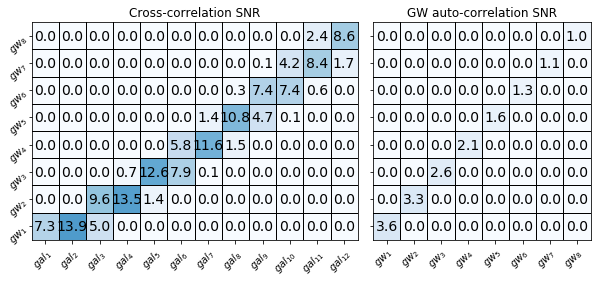

In [11]:
SN_sqr_matrix = GWGC_SN_sqr_matrix
vmin = np.sqrt(GWGC_SN_sqr_lst).min()
vmax = np.sqrt(GWGC_SN_sqr_lst).max() + 10.


import matplotlib.colors as colors

fig = plt.figure(figsize = (12.5, 4.))
axes = fig.subplots(1, 2, sharey='row', gridspec_kw={'wspace': -0.3})


im = axes[0].imshow(np.sqrt(SN_sqr_matrix), 
    vmin = vmin, vmax = vmax, cmap ='Blues', origin ='lower')

# We want to show all ticks...
axes[0].set_xticks(np.arange(len(gals)))
axes[0].set_yticks(np.arange(len(gws)))
# ... and label them with the respective list entries
axes[0].set_xticklabels(gals)
axes[0].set_yticklabels(gws)


[axes[0].axhline(y = i, linestyle = '-', c = "k", lw = 1) for i in np.arange(len(gws)) - 0.5]
[axes[0].axvline(x = i, linestyle = '-', c = "k", lw = 1) for i in np.arange(len(gals)) + 0.5]

# Rotate the tick labels and set their alignment.
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(N_DL):
    for j in range(N_gal):

        text = axes[0].text(j, i, round(np.sqrt(SN_sqr_matrix[i, j]), 1), fontsize = 14,
                       ha="center", va="center", color = "black")
        
        
        
        
### -- Autocorrelation --- ###

SN_sqr_matrix = GWGW_SN_sqr_matrix

im = axes[1].imshow(np.sqrt(SN_sqr_matrix), 
    vmin = vmin, vmax = vmax, cmap ='Blues', origin ='lower')

# We want to show all ticks...
axes[1].set_xticks(np.arange(len(gws)))
axes[1].set_yticks(np.arange(len(gws)))
# ... and label them with the respective list entries
axes[1].set_xticklabels(gws)
axes[1].set_yticklabels(gws)


[axes[1].axhline(y = i, linestyle = '-', c = "k", lw = 1) for i in np.arange(len(gws)) - 0.5]
[axes[1].axvline(x = i, linestyle = '-', c = "k", lw = 1) for i in np.arange(len(gws)) + 0.5]

# Rotate the tick labels and set their alignment.
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(axes[1].get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(N_DL):
    for j in range(N_DL):
        
        text = axes[1].text(j, i, round(np.sqrt(SN_sqr_matrix[i, j]), 1), fontsize = 14,
                       ha="center", va="center", color = "black")
            

axes[0].set_title("Cross-correlation SNR")
axes[1].set_title("GW auto-correlation SNR")
